In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import mplhep as hep
import pickle
import pandas as pd
import glob

In [3]:
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"):
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return pack(events)

def pack(events):
    events.info=ak.zip({
        "runNum": events.runNum,
        "lumiNum": events.lumiNum,
        "evtNum": events.eventNum,
        }
    )
    events.cls=ak.zip({
        'eta':events.ca4CSCclusterEta,
        'phi':events.ca4CSCclusterPhi,
        'x':events.ca4CSCclusterX,        
        'y':events.ca4CSCclusterY,
        'z':events.ca4CSCclusterZ,                
        'size':events.ca4CSCclusterSize,
        'time':events.ca4CSCclusterTime,
        'timeSpread':events.ca4CSCclusterTimeSpread,            
        "nME11_12": events.ca4CSCclusterME11_12,
        'time':events.ca4CSCclusterTime,            
        "nStation10": events.ca4CSCclusterNstation10,
        "avgStation10": events.ca4CSCclusterAvgStation10,            
        }    
    )
    events.cls_dt=ak.zip({
        'eta': events.ca4DTclusterEta,
        'phi': events.ca4DTclusterPhi,
        'x':   events.ca4DTclusterX,        
        'y':   events.ca4DTclusterY,
        'z':   events.ca4DTclusterZ,                
        'size':events.ca4DTclusterSize,
        'time':events.ca4DTclusterTime,
        "nMB1": events.ca4DTclusterMB1,
        "nMB2": events.ca4DTclusterMB2,            
        "nStation10": events.ca4DTclusterNstation10,
        "avgStation10": events.ca4DTclusterAvgStation10,            
        }    
    )
    return events

def plotCls(d=[{"cls":"cls","label":"data"}],version="new",density=False):
    
    fig, axs = plt.subplots(6,2,figsize=(16,36))
#     hep.set_style(hep.style.CMS)
    plt.style.use(hep.style.CMS) 
    axs = axs.flatten()
    density = density
    h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))
    h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("eta", "eta", 40, -5, 5))    
    h3= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("phi", "phi", 40, -np.pi, np.pi))        
    h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("size", "size", 100, 0, 1000))        
    h5= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("time", 'ClusterTime[ns]',80, -80, 80))            
    if version=="DT":
        h6 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nMB1", 'nMB1',40, 0, 40))
        h12= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nMB2", "nMB2", 40, 0, 40))        
    else:
        h6 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nME11_12", 'nME11_12',40, 0, 40))        
        h12= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("timeSpread", "timeSpread[ns]", 80, 0, 100))
        
    h7 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("x", "x", 100, -1000, 1000))        
    h8 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("y", "y", 100, -1000, 1000))        
    h9 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("z", "z", 100, -1000, 1000))            
    h10= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Nstation10", "Nstation10", 8, 0, 8))    
    h11= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("AvgStation10", "AvgStation10", 40, 0, 8))    
    
    hall = [h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12]
    for sample in d:
        cls = sample['cls']
        label = sample['label']
        h1.fill(sample=label,nClusters=ak.num(cls))
        h2.fill(sample=label,eta = ak.flatten(cls.eta))
        h3.fill(sample=label,phi = ak.flatten(cls.phi)) 
        h4.fill(sample=label,size = ak.flatten(cls.size))
        h5.fill(sample=label,time = ak.flatten(cls.time)) 
        if version=="DT":
            h6.fill (sample=label,nMB1 = ak.flatten(cls.nMB1))        
            h12.fill(sample=label,nMB2 = ak.flatten(cls.nMB2))                
        elif version=="new":
            h6.fill (sample=label,nME11_12 = ak.flatten(cls.nME11_12))
            h12.fill(sample=label,timeSpread = ak.flatten(cls.timeSpread))                
        else:
            h6.fill(sample=label,nME11_12 = ak.flatten(cls.nME11+cls.nME12))        

        h7.fill( sample=label,x = ak.flatten(cls.x))    
        h8.fill( sample=label,y = ak.flatten(cls.y))    
        h9.fill( sample=label,z = ak.flatten(cls.z))        
        h10.fill(sample=label,Nstation10 = ak.flatten(cls.nStation10))            
        h11.fill(sample=label,AvgStation10 = ak.flatten(cls.avgStation10))                
    
    
    hist.plot1d(h1,density=density,ax=axs[0])
    hist.plot1d(h2,density=density,ax=axs[1])
    hist.plot1d(h3,density=density,ax=axs[2])
    hist.plot1d(h4,density=density,ax=axs[3])
    hist.plot1d(h5,density=density,ax=axs[4])
    hist.plot1d(h6,density=density,ax=axs[5])    
    hist.plot1d(h7,density=density,ax=axs[6])    
    hist.plot1d(h8,density=density,ax=axs[7])    
    hist.plot1d(h9,density=density,ax=axs[8])    
    hist.plot1d(h10,density=density,ax=axs[9])    
    hist.plot1d(h11,density=density,ax=axs[10])    
    hist.plot1d(h12,density=density,ax=axs[11])        
    
    if density:
        axs[5].set_yscale("log")
        axs[5].set_ylim(1e-4,None)
    axs[3].set_yscale("log")
    axs[3].set_ylim(1e-4,None)
        
    for ax in axs:
        hep.cms.label(ax=ax,data=True,label="Preliminary")        
#         ax.legend([label])
    plt.tight_layout()
    plt.show()
    

In [4]:
events = getLZDF("../analyze_355100.root")

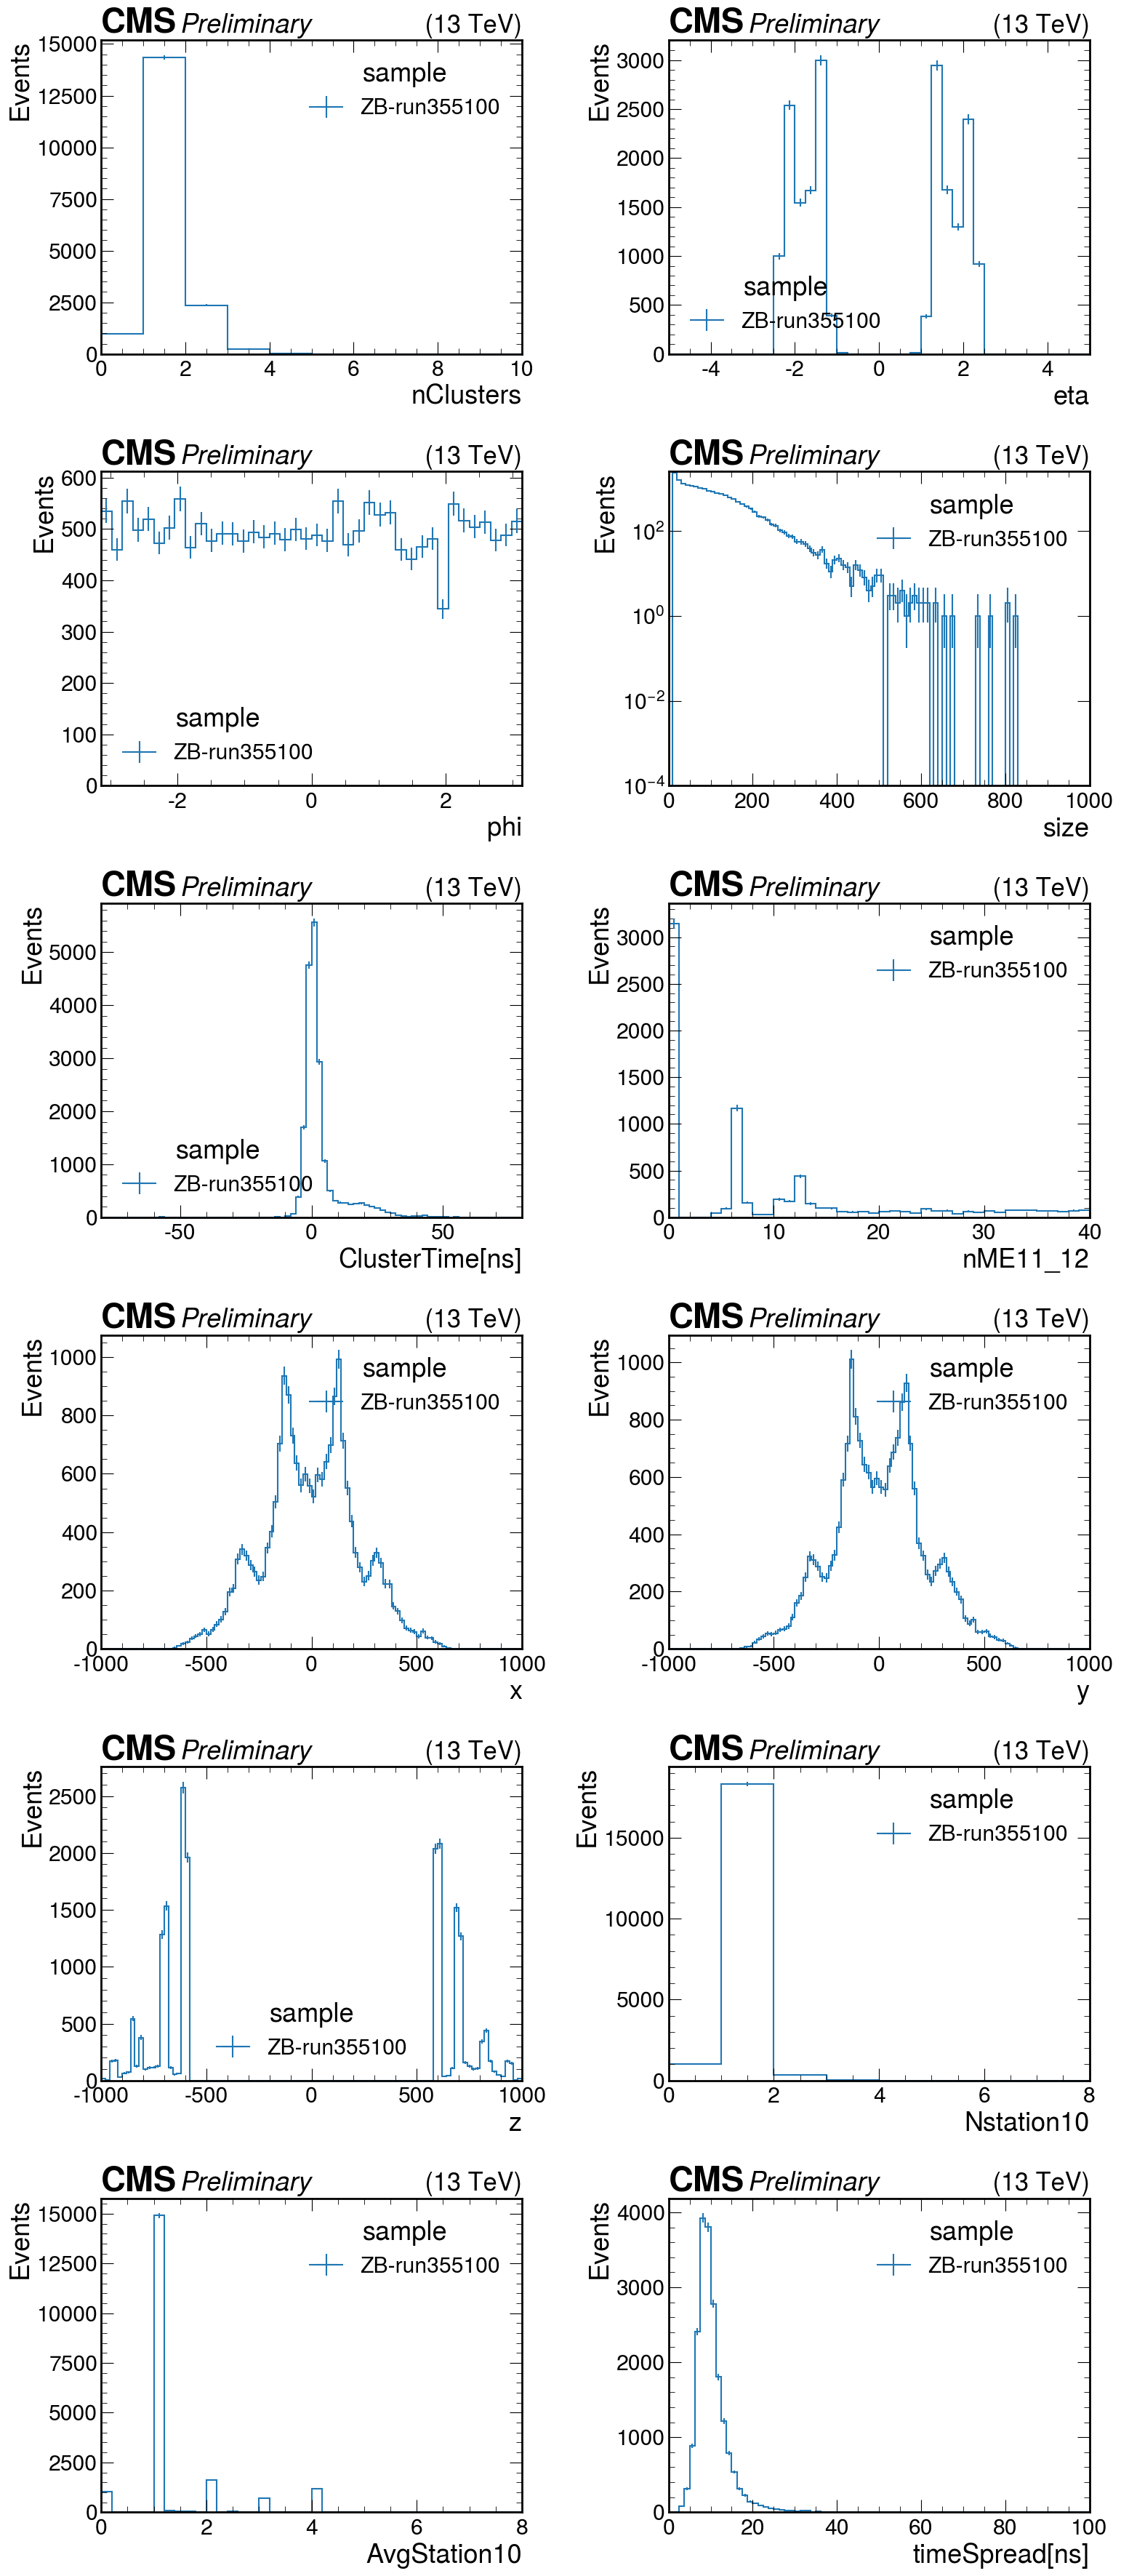

In [5]:
# plt.style.use("default")

samples=[
    {"cls":events.cls,"label":"ZB-run355100"},
#     {"cls":cutFlow_csc,"label":"cutFlow_csc"},
#     {"cls":events.cls[csc][mask][notHLT],"label":"cutflow, not HLT"},    

]
plotCls(samples,"new",False)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

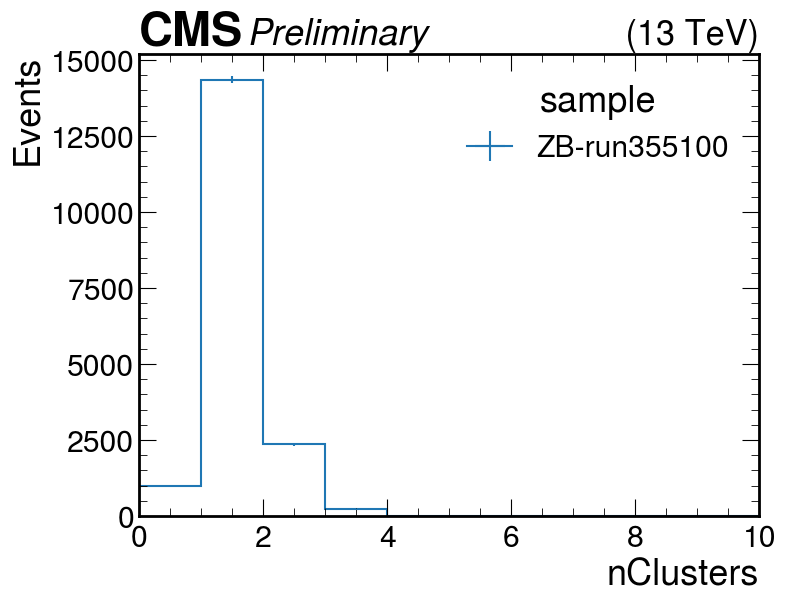

In [29]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,1, figsize=(8,6))
h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))        
h4.fill(sample="ZB-run355100",nClusters=ak.num(events.cls))
ax=hist.plot1d(h4)
# ax.set_yscale("log")
# ax.set_ylim(0.5,None)

hep.cms.label(ax=ax,data=True,label="Preliminary")

In [ ]:
plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(1,1, figsize=(8,6))
h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("size", "size", 100, 0, 1000))        
h4.fill(sample="ZB-run355100",size=ak.flatten(events.cls.size))
ax=hist.plot1d(h4)
ax.set_yscale("log")
ax.set_ylim(0.5,None)

hep.cms.label(ax=ax,data=True,label="Preliminary")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

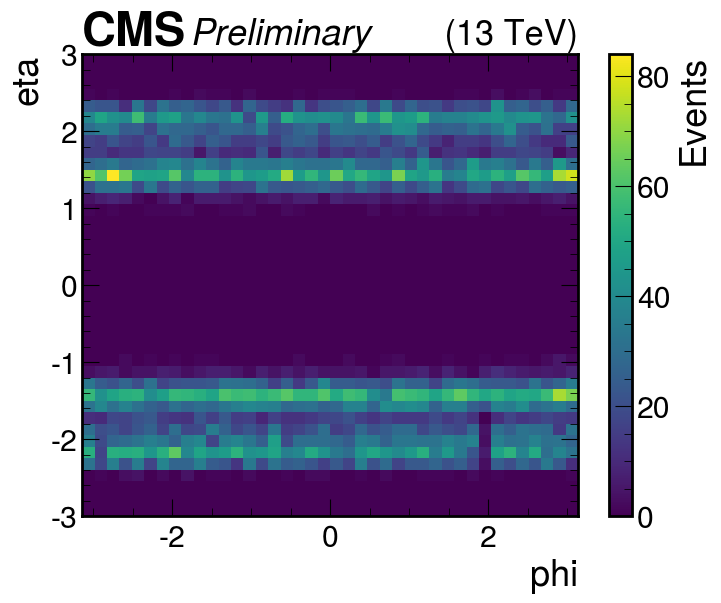

In [26]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
h= hist.Hist("Events",
              hist.Bin("eta", "eta", 40, -3, 3),
              hist.Bin("phi", "phi", 40, -np.pi, np.pi)  )
h.fill(eta=ak.flatten(events.cls.eta),phi=ak.flatten(events.cls.phi))
hist.plot2d(h,xaxis="phi",ax=ax)
hep.cms.label(ax=ax,data=True,label="Preliminary")

In [10]:
ak.num(cls)

<Array [1, 1, 1, 2, 1, 1, ... 0, 2, 1, 1, 2, 2] type='17933 * int64'>

In [7]:
# ca4CSCclusterSize
cls = ak.zip(
    {k.replace("ca4CSCcluster",""):getattr(events,k) for k in events.fields if k.startswith("ca4CSCcluster")}
    ,with_name="PtEtaPhiMLorentzVector", 
    behavior=vector.behavior
    )

In [6]:
events.fields

['runNum',
 'lumiNum',
 'eventNum',
 'passL1',
 'processedL1',
 'HLT_DtCluster50_v0',
 'HLT_DtCluster100_v0',
 'HLT_DtCluster50NoVeto_v0',
 'HLT_DtCluster100NoVeto_v0',
 'HLT_CscCluster50InTime_v0',
 'HLT_CscCluster100InTime_v0',
 'HLT_CscCluster150InTime_v0',
 'HLT_CscCluster200InTime_v0',
 'HLT_CscCluster225InTime_v0',
 'HLT_CscCluster50OOT_v0',
 'HLT_CscCluster100OOT_v0',
 'HLT_CscCluster150OOT_v0',
 'HLT_CscCluster200OOT_v0',
 'HLT_CscCluster225OOT_v0',
 'HLT_CscCluster100InTimeNoVeto_v0',
 'gLLP_eta',
 'gLLP_phi',
 'gLLP_csc',
 'gLLP_dt',
 'gLLP_beta',
 'gLLP_e',
 'gLLP_pt',
 'gLLP_ctau',
 'gLLP_decay_vertex_r',
 'gLLP_decay_vertex_x',
 'gLLP_decay_vertex_y',
 'gLLP_decay_vertex_z',
 'nca4CSCcluster',
 'ca4CSCclusterSize',
 'ca4CSCclusterX',
 'ca4CSCclusterY',
 'ca4CSCclusterZ',
 'ca4CSCclusterEta',
 'ca4CSCclusterPhi',
 'ca4CSCclusterTpeak',
 'ca4CSCclusterWireTime',
 'ca4CSCclusterTime',
 'ca4CSCclusterTimeSpread',
 'ca4CSCclusterME11_12',
 'ca4CSCclusterNstation10',
 'ca4CSCclu

In [32]:
def display(i_event,cls,save=False):
#     i_event = 3
    plt.style.use(hep.style.CMS) 
    i_cls = cls[i_event]
    fig, axs = plt.subplots(1,1, figsize=(8,6))

    axs.scatter(i_cls.Eta,i_cls.Phi,s=i_cls.Size,label="Cluster")
    for cl in i_cls:
        cone = plt.Circle((cl.Eta, cl.Phi), 0.4, color='b', fill=False,)
        axs.add_patch(cone)
    axs.set_ylim(-5,5)
    axs.set_xlim(-5,5)
    axs.set_ylabel(r"$\phi$")
    axs.set_xlabel(r"$\eta$")
    leg = axs.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    hep.cms.label(ax=axs,data=True,label="Preliminary")    
    for l in leg.legendHandles:
        l._sizes = [30]
    print("Cluster eta  = ",cls[i_event].Eta)
    print("Cluster phi  = ",cls[i_event].Phi)
    print("Cluster Size  = ",cls[i_event].Size)
    print("Cluster time  = ",cls[i_event].Time)
    if save:
        fig.savefig("eventDisplay_%s.pdf"%i_event)

In [37]:
ak.max(ak.num(cls.Size))

4

In [38]:
np.where(ak.num(cls.Size)>3)

(<Array [1226, 1888, 2706, ... 13755, 16933] type='12 * int64'>,)

In [34]:
np.where(ak.any(cls.Size==ak.max(cls.Size),axis=1))

(<Array [13795] type='1 * int64'>,)

Cluster eta  =  [-2.33, -1.93, -2.38, 2.19]
Cluster phi  =  [-0.738, 2.54, -3.05, 0.0402]
Cluster Size  =  [12, 12, 11, 130]
Cluster time  =  [-5.14, -2.23, 1.06, -4.66]


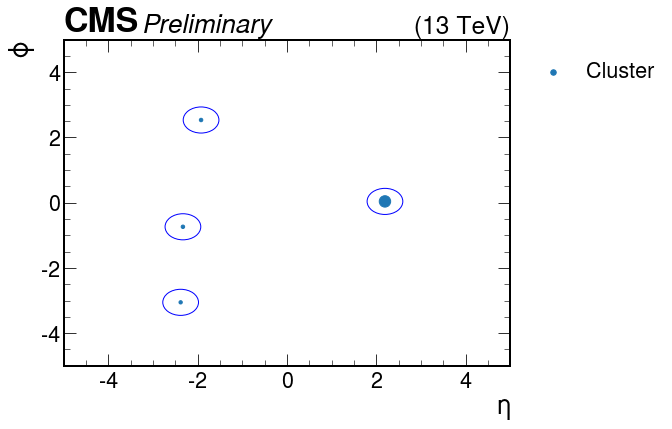

In [39]:
display(2706,cls)

Cluster eta  =  [-2.24, -2.06]
Cluster phi  =  [-0.505, 0.832]
Cluster Size  =  [172, 15]
Cluster time  =  [-1.44, 3.39]


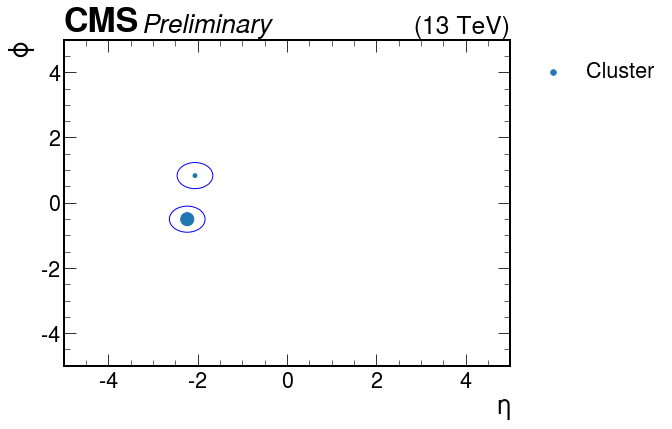

In [35]:
display(17928,cls)

Cluster eta  =  [1.52]
Cluster phi  =  [-1.94]
Cluster Size  =  [1.49e+03]
Cluster time  =  [2.29]


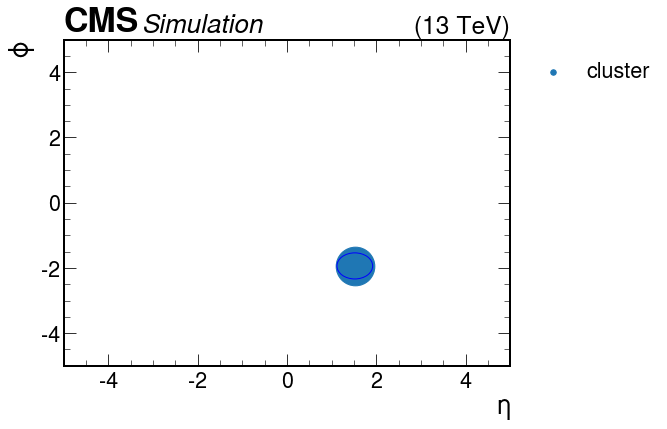

In [24]:
display(13795,cls)